<a href="https://colab.research.google.com/github/supunabeywickrama/my-colab-work/blob/main/tiny_anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
# If in Colab, uncomment next line:
!pip install torch torchvision matplotlib scikit-learn

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import datasets, transforms
import numpy as np, random, matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import itertools, os, json
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED=42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
print("Device:", DEVICE)


Device: cuda


In [30]:
NORMAL_LABEL = 0   # T-shirt/top
ANOM_LABEL   = 7   # Sneaker

tfm = transforms.Compose([
    transforms.ToTensor(),          # [0,1], shape [1,28,28]
])

root = "./data"
train_all = datasets.FashionMNIST(root, train=True,  download=True, transform=tfm)
test_all  = datasets.FashionMNIST(root, train=False, download=True, transform=tfm)

# Build subsets:
train_idx = [i for i,(x,y) in enumerate(train_all) if y==NORMAL_LABEL]
test_ok_idx = [i for i,(x,y) in enumerate(test_all) if y==NORMAL_LABEL]
test_ng_idx = [i for i,(x,y) in enumerate(test_all) if y==ANOM_LABEL]

# Keep it small/fast (tweak as you like)
train_idx = train_idx[:5000]
test_ok_idx = test_ok_idx[:500]
test_ng_idx = test_ng_idx[:500]

train_ds = Subset(train_all, train_idx)
test_ok_ds = Subset(test_all, test_ok_idx)
test_ng_ds = Subset(test_all, test_ng_idx)

BATCH=128
train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, num_workers=0)
test_ok_loader = DataLoader(test_ok_ds, batch_size=1, shuffle=False)
test_ng_loader = DataLoader(test_ng_ds, batch_size=1, shuffle=False)

len(train_ds), len(test_ok_ds), len(test_ng_ds)


(5000, 500, 500)

# Tiny Conv Autoencoder

In [31]:
class ConvAE(nn.Module):
    def __init__(self):
        super().__init__()
        # input: 1x28x28
        self.enc = nn.Sequential(
            nn.Conv2d(1,16,3,2,1), nn.ReLU(),   # 16x14x14
            nn.Conv2d(16,32,3,2,1), nn.ReLU(),  # 32x7x7
            nn.Conv2d(32,64,3,1,1), nn.ReLU(),  # 64x7x7
        )
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(64,32,4,2,1), nn.ReLU(),  # 32x14x14
            nn.ConvTranspose2d(32,16,4,2,1), nn.ReLU(),  # 16x28x28
            nn.Conv2d(16,1,3,1,1), nn.Sigmoid()          # 1x28x28
        )
    def forward(self,x): return self.dec(self.enc(x))

model = ConvAE().to(DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
crit = nn.L1Loss()  # L1 often better than MSE for recon clarity


# Train on normal only

In [32]:
EPOCHS=300
for ep in range(1, EPOCHS+1):
    model.train()
    total=0
    for x,y in train_loader:
        x = x.to(DEVICE)
        yhat = model(x)
        loss = crit(yhat, x)
        opt.zero_grad(); loss.backward(); opt.step()
        total += loss.item()*x.size(0)
    print(f"Epoch {ep:02d} | Train L1: {total/len(train_ds):.4f}")


Epoch 01 | Train L1: 0.2334
Epoch 02 | Train L1: 0.0992
Epoch 03 | Train L1: 0.0716
Epoch 04 | Train L1: 0.0619
Epoch 05 | Train L1: 0.0566
Epoch 06 | Train L1: 0.0533
Epoch 07 | Train L1: 0.0508
Epoch 08 | Train L1: 0.0501
Epoch 09 | Train L1: 0.0473
Epoch 10 | Train L1: 0.0474
Epoch 11 | Train L1: 0.0450
Epoch 12 | Train L1: 0.0439
Epoch 13 | Train L1: 0.0435
Epoch 14 | Train L1: 0.0419
Epoch 15 | Train L1: 0.0414
Epoch 16 | Train L1: 0.0410
Epoch 17 | Train L1: 0.0402
Epoch 18 | Train L1: 0.0412
Epoch 19 | Train L1: 0.0390
Epoch 20 | Train L1: 0.0390
Epoch 21 | Train L1: 0.0381
Epoch 22 | Train L1: 0.0380
Epoch 23 | Train L1: 0.0376
Epoch 24 | Train L1: 0.0372
Epoch 25 | Train L1: 0.0370
Epoch 26 | Train L1: 0.0366
Epoch 27 | Train L1: 0.0359
Epoch 28 | Train L1: 0.0360
Epoch 29 | Train L1: 0.0359
Epoch 30 | Train L1: 0.0351
Epoch 31 | Train L1: 0.0357
Epoch 32 | Train L1: 0.0348
Epoch 33 | Train L1: 0.0344
Epoch 34 | Train L1: 0.0339
Epoch 35 | Train L1: 0.0340
Epoch 36 | Train L1:

# Scoring function (reconstruction error)

In [33]:
@torch.no_grad()
def score_loader(loader):
    model.eval()
    scores = []
    ims = []
    recons = []
    for x,y in loader:
        x = x.to(DEVICE)
        yhat = model(x)
        # scalar anomaly score: mean absolute error
        s = (x-yhat).abs().mean(dim=(1,2,3)).cpu().numpy()
        scores.extend(s.tolist())
        ims.append(x.cpu())
        recons.append(yhat.cpu())
    return np.array(scores), torch.cat(ims,dim=0), torch.cat(recons,dim=0)

ok_scores, ok_x, ok_yhat = score_loader(test_ok_loader)
ng_scores, ng_x, ng_yhat = score_loader(test_ng_loader)

scores = np.concatenate([ok_scores, ng_scores])
labels = np.concatenate([np.zeros_like(ok_scores), np.ones_like(ng_scores)])  # 0=normal,1=anomaly


# Pick a threshold using ROC (target FPR ≈ 1%)

In [34]:
fpr, tpr, thr = roc_curve(labels, scores)
roc_auc = auc(fpr, tpr)
print("ROC-AUC:", roc_auc)

# choose highest threshold with FPR <= 0.01 (or fallback to best overall)
target_fpr = 0.01
idx = np.where(fpr <= target_fpr)[0]
T = float(thr[idx[-1]] if len(idx) else thr[np.argmax(tpr - fpr)])
print("Chosen threshold:", T)

# Quick report at that threshold
pred = (scores >= T).astype(int)
cm = confusion_matrix(labels, pred)
print(cm)
print(classification_report(labels, pred, target_names=["Normal","Anomaly"]))


ROC-AUC: 0.71792
Chosen threshold: 0.05156348645687103
[[499   1]
 [500   0]]
              precision    recall  f1-score   support

      Normal       0.50      1.00      0.67       500
     Anomaly       0.00      0.00      0.00       500

    accuracy                           0.50      1000
   macro avg       0.25      0.50      0.33      1000
weighted avg       0.25      0.50      0.33      1000



# Visualize reconstructions + heatmaps

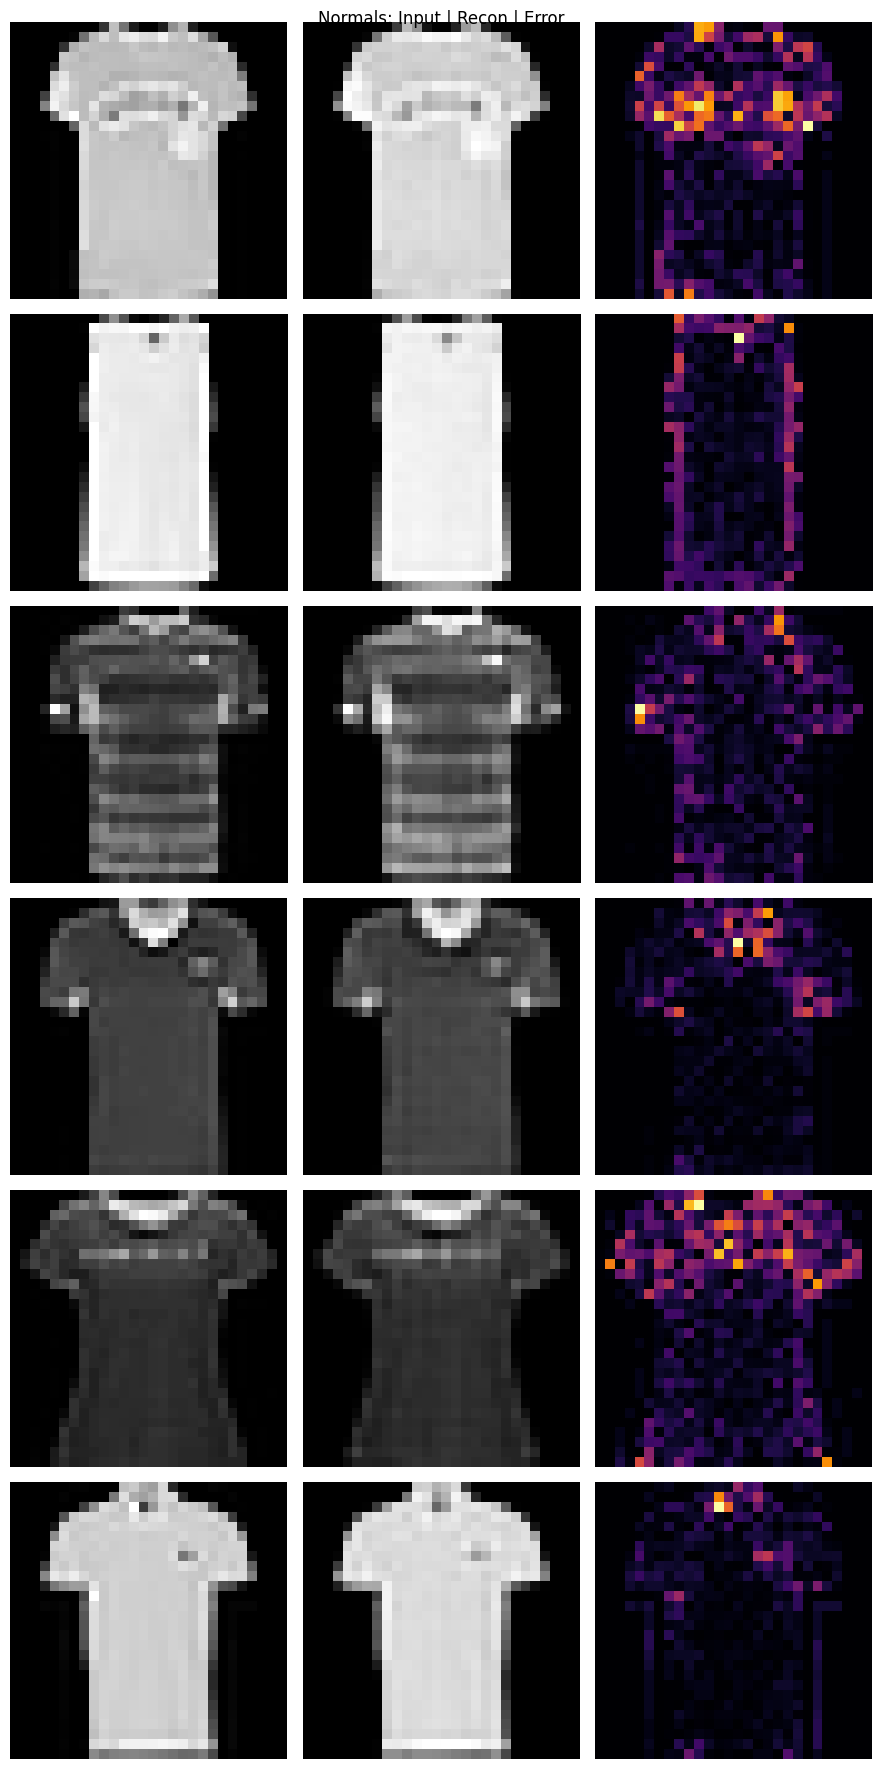

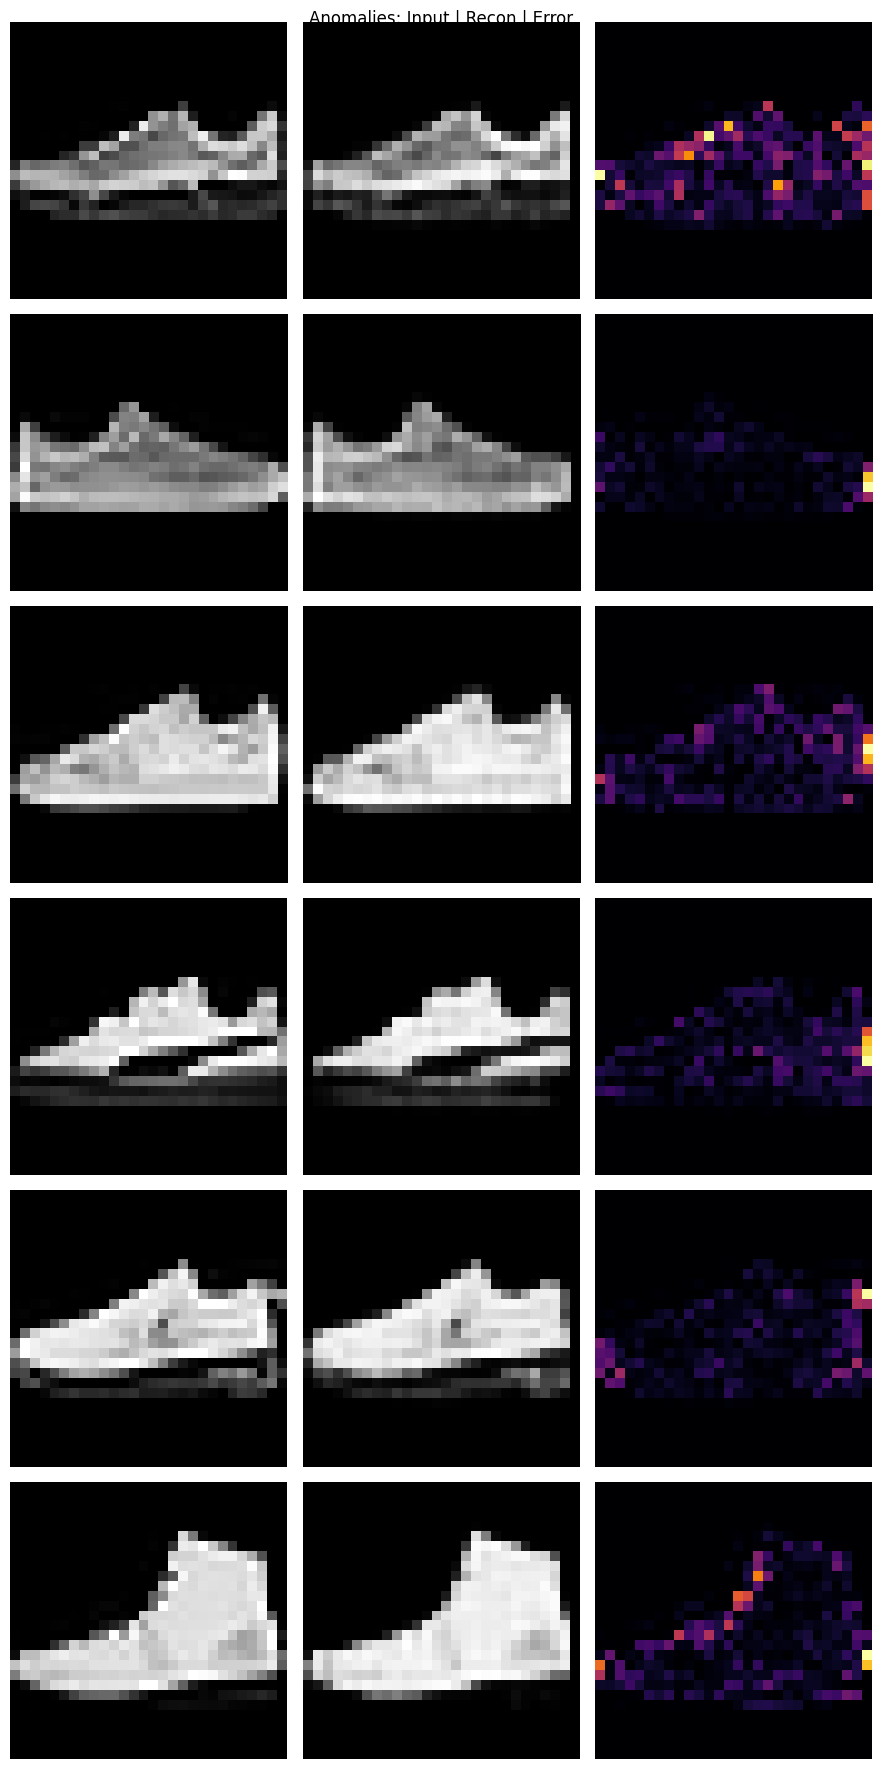

In [35]:
def show_triplet(x, yhat, n=6, title=""):
    x = x[:n].squeeze().numpy()
    y = yhat[:n].squeeze().numpy()
    err = np.abs(x - y)
    plt.figure(figsize=(9,3*n))
    for i in range(n):
        plt.subplot(n,3,3*i+1); plt.imshow(x[i], cmap="gray"); plt.axis('off')
        plt.subplot(n,3,3*i+2); plt.imshow(y[i], cmap="gray"); plt.axis('off')
        plt.subplot(n,3,3*i+3);
        em = (err[i]-err[i].min())/(err[i].max()-err[i].min()+1e-8)
        plt.imshow(em, cmap="inferno"); plt.axis('off')
    plt.suptitle(title); plt.tight_layout(); plt.show()

show_triplet(ok_x, ok_yhat, n=6, title="Normals: Input | Recon | Error")
show_triplet(ng_x, ng_yhat, n=6, title="Anomalies: Input | Recon | Error")


# Save model + **threshold**

In [36]:
os.makedirs("artifacts", exist_ok=True)
torch.save(model.state_dict(), "artifacts/fmnist_ae.pt")
with open("artifacts/threshold.json","w") as f:
    json.dump({"threshold":T, "normal_label": int(NORMAL_LABEL), "anomaly_label": int(ANOM_LABEL)}, f)
print("Saved to artifacts/")


Saved to artifacts/


# Simple infer()  can reuse later

In [37]:
@torch.no_grad()
def infer(img_tensor_1x28x28):  # torch.float32 in [0,1], shape [1,28,28]
    model.eval()
    x = img_tensor_1x28x28.unsqueeze(0).to(DEVICE)  # [1,1,28,28]
    y = model(x)
    err_map = (x-y).abs().squeeze().cpu().numpy()
    score = err_map.mean().item()
    verdict = "NG" if score >= T else "OK"
    # binary mask (optional)
    em = (err_map - err_map.min())/(err_map.max()-err_map.min()+1e-8)
    mask = (em > np.clip(em.mean()+2*em.std(), 0.2, 0.9)).astype(np.uint8)
    return verdict, float(score), mask, em

# quick demo on one normal and one anomaly sample
v0, s0, m0, em0 = infer(ok_x[0])
v1, s1, m1, em1 = infer(ng_x[0])
print("Normal sample verdict:", v0, s0)
print("Anomaly sample verdict:", v1, s1)


Normal sample verdict: OK 0.010778648778796196
Anomaly sample verdict: OK 0.017679832875728607
